#### 주제 : 주조 공정의 온실가스 배출량 예측 및 죄적화 

#### 변수 설정
-----------------------------------------------------------------------------------------------------------------
온도 관련 변수 
 - molten_temp (용탕 온도) : 금속을 녹이는 온도
 - upper_mold_temp1, upper_mold_temp2, upper_mold_temp3, lower_mold_temp1, lower_mold_temp2, lower_mold_temp3 (상/하형 온도): 주조 시 주형의 온도
 - sleeve_temperature (슬리브 온도) 

압력 및 속도 관련 변수
 - cast_pressure (주조 압력)
 - low_section_speed, high_section_speed (주조 속도)
 
설비 및 공정 시간 관련 변수
 - facility_operation_cycleTime (설비 운영 사이클 타임)
 - production_cycletime (생산 사이클 타임)
 - EMS_operation_time (EMS 운영 시간)

기타 에너지 관련 변수 및 에너지 상태 중단 관련 변수
 - Coolant_temperature (냉각수 온도)
 - heating_furnace (가열로 상태)

 - emergency_stop (비상 정지)
 - working (작동 상태)
-----------------------------------------------------------------------------------------------------------------


[1] 모듈 호출

In [254]:
# 모듈로딩
# - Model 관련 
import torch                                    # 텐서 및 수치 계산 함수 관련 모듈 
import torch.nn as nn                           # 인공신경망 관련 모듈 
import torch.nn.functional as F                 # 손실, 거래 등 함수 관련 모듈 
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim                     # weight,  bias 최적화 기반 관련 모듈
import torch.optim.lr_scheduler as lr_scheduler # 최적화 스케줄링 관련 모듈 

from torchmetrics.regression import R2Score, MeanAbsoluteError # 성능지표 관련 모듈
from torchinfo import summary
from sklearn.preprocessing import StandardScaler # 표준화 스케일링
import joblib

# Data 처리 및 시각화 관련
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split
import seaborn as sns
import koreanize_matplotlib                     # 시각화 한글 호환
from scipy.stats.mstats import winsorize        # 원저화

[2] 데이터 로딩

In [242]:
data = pd.read_csv(r"C:\Hwan\K-AI & project\경진대회용 주조 공정최적화 데이터셋.csv", encoding='cp949')
data = pd.DataFrame(data)
data

C:\Users\hwans\AppData\Local\Temp\ipykernel_22800\1380534819.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r"C:\Hwan\K-AI & project\경진대회용 주조 공정최적화 데이터셋.csv", encoding='cp949')


,Unnamed: 0,line,name,mold_name,time,date,count,working,emergency_stop,molten_temp,...,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,registration_time,passorfail,tryshot_signal,mold_code,heating_furnace
0,0,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:45:06,258,가동,ON,731.0,...,1449.0,550.0,700.0,34.0,23,2019-01-02 16:45:06,0.0,NaN,8722,NaN
1,1,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:45:08,243,가동,ON,720.0,...,NaN,481.0,0.0,30.0,25,2019-01-02 16:45:08,0.0,NaN,8412,B
2,2,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:45:58,244,가동,ON,721.0,...,NaN,481.0,0.0,30.0,25,2019-01-02 16:45:58,0.0,NaN,8412,B
3,3,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:48:03,245,가동,ON,721.0,...,NaN,483.0,0.0,30.0,25,2019-01-02 16:48:03,0.0,NaN,8412,B
4,4,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:50:08,246,가동,ON,721.0,...,NaN,486.0,0.0,30.0,25,2019-01-02 16:50:08,0.0,NaN,8412,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92010,92010,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-03-31,23:51:29,71,가동,ON,731.0,...,1449.0,279.0,726.0,30.0,0,2019-03-31 23:51:29,0.0,NaN,8917,A
92011,92011,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-03-31,23:53:28,72,가동,ON,731.0,...,1449.0,279.0,732.0,30.0,0,2019-03-31 23:53:28,0.0,NaN,8917,A
92012,92012,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-03-31,23:55:44,73,가동,ON,732.0,...,1449.0,272.0,731.0,30.0,0,2019-03-31 23:55:44,0.0,NaN,8917,A
92013,92013,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-03-31,23:57:46,74,가동,ON,732.0,...,1449.0,288.0,723.0,30.0,0,2019-03-31 23:57:46,0.0,NaN,8917,A


In [243]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92015 entries, 0 to 92014
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    92015 non-null  int64  
 1   line                          92015 non-null  object 
 2   name                          92015 non-null  object 
 3   mold_name                     92015 non-null  object 
 4   time                          92015 non-null  object 
 5   date                          92015 non-null  object 
 6   count                         92015 non-null  int64  
 7   working                       92014 non-null  object 
 8   emergency_stop                92014 non-null  object 
 9   molten_temp                   89754 non-null  float64
 10  facility_operation_cycleTime  92015 non-null  int64  
 11  production_cycletime          92015 non-null  int64  
 12  low_section_speed             92014 non-null  float64
 13  h

[2-1] 데이터 전처리
- [1] 결측치 처리
- 결측치의 수가 데이터의 5% 이상인 칼럼은 삭제 
- 그 이하는 모델의 정확도를 위해 평균값으로 대체
- [2] 인코딩 
- working 칼럼에서 가동/정지 => 원핫인코딩 
- emergency_stop 칼럼 on/결측치(1) => 결측치 포함 행 삭제 
- [3] data 스케일링 
- 표준화를 통한 스케일링 
- [4] 이상치 
- 각 칼럼별 이상치가 많이 존재 -> 제거하는 것이 오히려 의미 있는 정보를 잃는 결과 ==> 이상치를 경계값으로 조정 (극단적인 값을 줄이는)
- Winsorization (원저화) 사용하여 상하위 5% 값들을 경계값을 제한
<hr>

In [244]:
# 결측치가 많은 칼럼 삭제 
data = data.drop(columns=['tryshot_signal', 'heating_furnace', 'Unnamed: 0', 'registration_time', "molten_volume"], errors='ignore')

# 결측치를 평균값으로 
data['molten_temp'].fillna(data['molten_temp'].mean(), inplace=True)
data['low_section_speed'].fillna(data['low_section_speed'].mean(), inplace=True)
data['high_section_speed'].fillna(data['high_section_speed'].mean(), inplace=True)
data['biscuit_thickness'].fillna(data['biscuit_thickness'].mean(), inplace=True)
data['upper_mold_temp1'].fillna(data['upper_mold_temp1'].mean(), inplace=True)
data['upper_mold_temp2'].fillna(data['upper_mold_temp2'].mean(), inplace=True)
data['upper_mold_temp3'].fillna(data['upper_mold_temp3'].mean(), inplace=True)
data['lower_mold_temp1'].fillna(data['lower_mold_temp1'].mean(), inplace=True)
data['lower_mold_temp2'].fillna(data['lower_mold_temp2'].mean(), inplace=True)
data['lower_mold_temp3'].fillna(data['lower_mold_temp3'].mean(), inplace=True)
data['sleeve_temperature'].fillna(data['sleeve_temperature'].mean(), inplace=True)
data['physical_strength'].fillna(data['physical_strength'].mean(), inplace=True)
data['Coolant_temperature'].fillna(data['Coolant_temperature'].mean(), inplace=True)
data['passorfail'].fillna(data['passorfail'].mean(), inplace=True)

[2-1-2] 인코딩

In [245]:
data["working"].value_counts()

working
가동    91963
정지       51
Name: count, dtype: int64

In [210]:
# emergency 행에서 결측치를 포함하는 행 삭제 
data = data.dropna(subset=['emergency_stop'])

# working 칼럼 원핫 인코딩
# 가동 True = 1 // 가동 Flase = 0
data = pd.get_dummies(data, columns=['working'])

In [211]:
# 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92014 entries, 0 to 92014
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   line                          92014 non-null  object 
 1   name                          92014 non-null  object 
 2   mold_name                     92014 non-null  object 
 3   time                          92014 non-null  object 
 4   date                          92014 non-null  object 
 5   count                         92014 non-null  int64  
 6   emergency_stop                92014 non-null  object 
 7   molten_temp                   92014 non-null  float64
 8   facility_operation_cycleTime  92014 non-null  int64  
 9   production_cycletime          92014 non-null  int64  
 10  low_section_speed             92014 non-null  float64
 11  high_section_speed            92014 non-null  float64
 12  cast_pressure                 92014 non-null  float64
 13  biscui

In [212]:
print(data["working_가동"].value_counts())
print(data["working_정지"].value_counts())

working_가동
True     91963
False       51
Name: count, dtype: int64
working_정지
False    91963
True        51
Name: count, dtype: int64


In [213]:
data = data.drop(columns=["working_정지"])

In [214]:
data["working_가동"] = data["working_가동"].astype(int)

In [215]:
# 최종 결측치 확인
data.isna().sum()

line                            0
name                            0
mold_name                       0
time                            0
date                            0
count                           0
emergency_stop                  0
molten_temp                     0
facility_operation_cycleTime    0
production_cycletime            0
low_section_speed               0
high_section_speed              0
cast_pressure                   0
biscuit_thickness               0
upper_mold_temp1                0
upper_mold_temp2                0
upper_mold_temp3                0
lower_mold_temp1                0
lower_mold_temp2                0
lower_mold_temp3                0
sleeve_temperature              0
physical_strength               0
Coolant_temperature             0
EMS_operation_time              0
passorfail                      0
mold_code                       0
working_가동                      0
dtype: int64

[2-1-3] 스케일링

In [216]:
# scaler = StandardScaler()
# numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
# data[numeric_features] = scaler.fit_transform(data[numeric_features])

[2-2] 상관관계 확인

In [217]:
data_corr = data.corr(numeric_only=True)

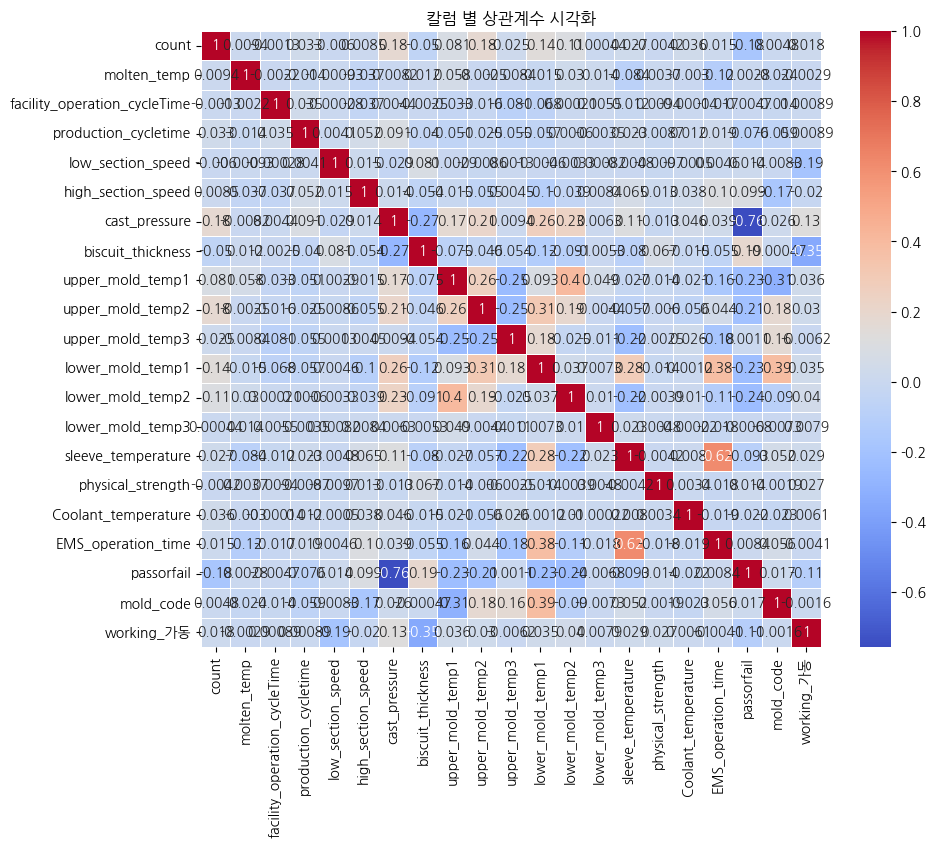

In [218]:
plt.figure(figsize=(10, 8))
sns.heatmap(data_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('칼럼 별 상관계수 시각화')
plt.show()

In [219]:
data.columns

Index(['line', 'name', 'mold_name', 'time', 'date', 'count', 'emergency_stop',
       'molten_temp', 'facility_operation_cycleTime', 'production_cycletime',
       'low_section_speed', 'high_section_speed', 'cast_pressure',
       'biscuit_thickness', 'upper_mold_temp1', 'upper_mold_temp2',
       'upper_mold_temp3', 'lower_mold_temp1', 'lower_mold_temp2',
       'lower_mold_temp3', 'sleeve_temperature', 'physical_strength',
       'Coolant_temperature', 'EMS_operation_time', 'passorfail', 'mold_code',
       'working_가동'],
      dtype='object')

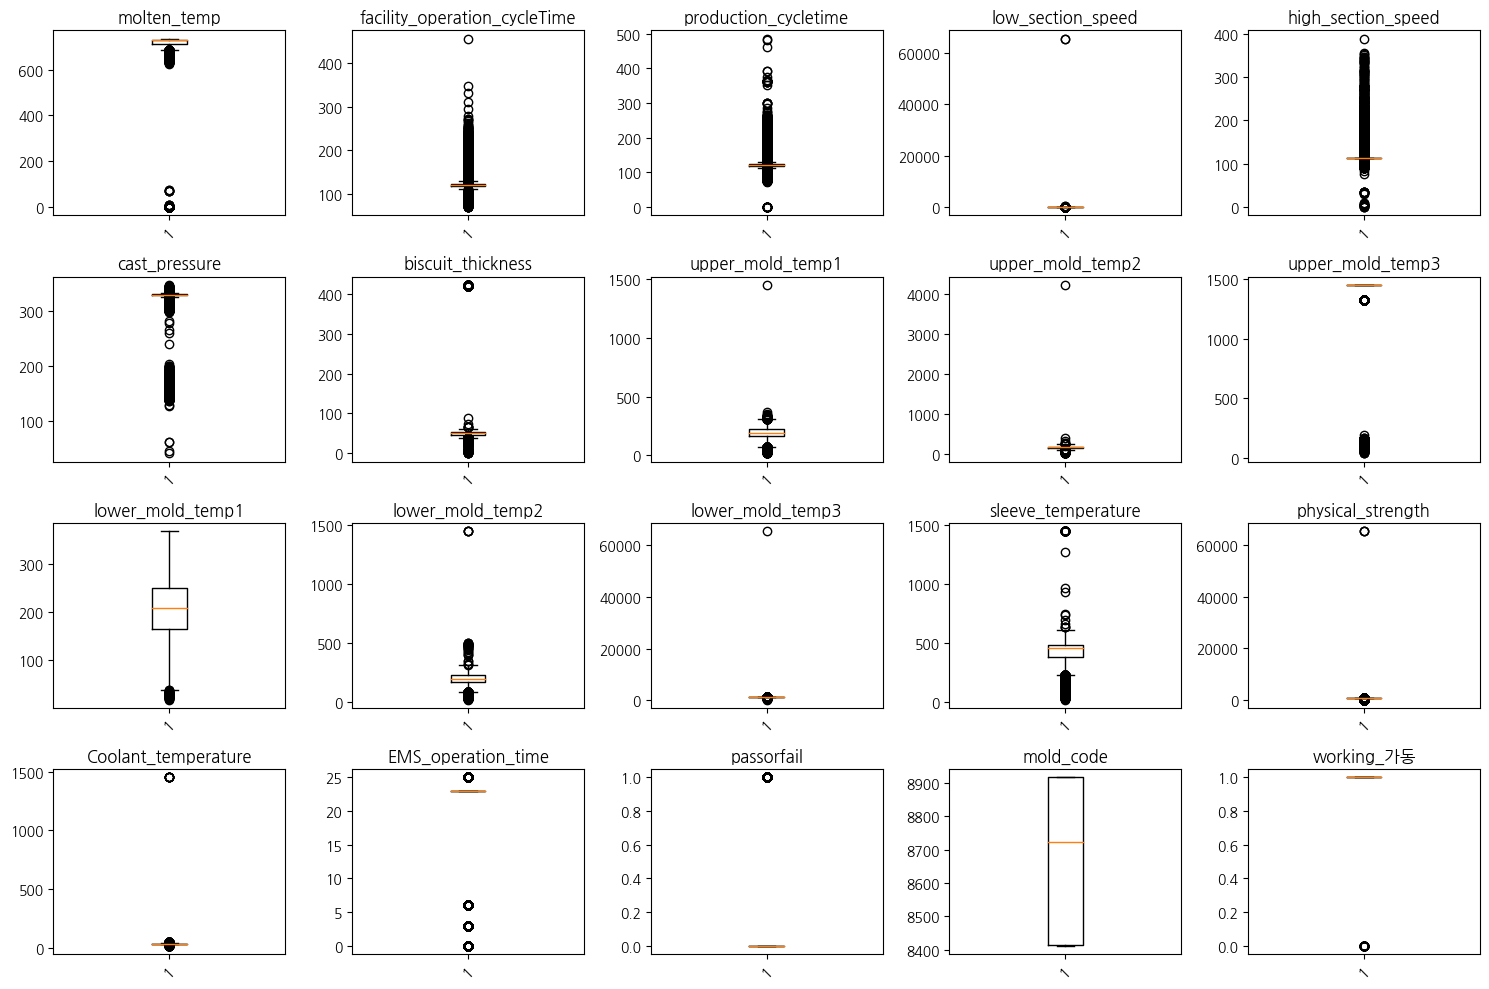

In [220]:
columnsList = ['molten_temp', 'facility_operation_cycleTime', 'production_cycletime',
       'low_section_speed', 'high_section_speed', 'cast_pressure',
       'biscuit_thickness', 'upper_mold_temp1', 'upper_mold_temp2',
       'upper_mold_temp3', 'lower_mold_temp1', 'lower_mold_temp2',
       'lower_mold_temp3', 'sleeve_temperature', 'physical_strength',
       'Coolant_temperature', 'EMS_operation_time', 'passorfail', 'mold_code',
       'working_가동']

plt.figure(figsize=(15, 10))
for i, col in enumerate(columnsList, 1):
    plt.subplot(4, 5, i)  
    plt.boxplot(data[col].dropna())
    plt.title(col)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

[2-1-4] 이상치를 경계값으로 조절 Winsorization 

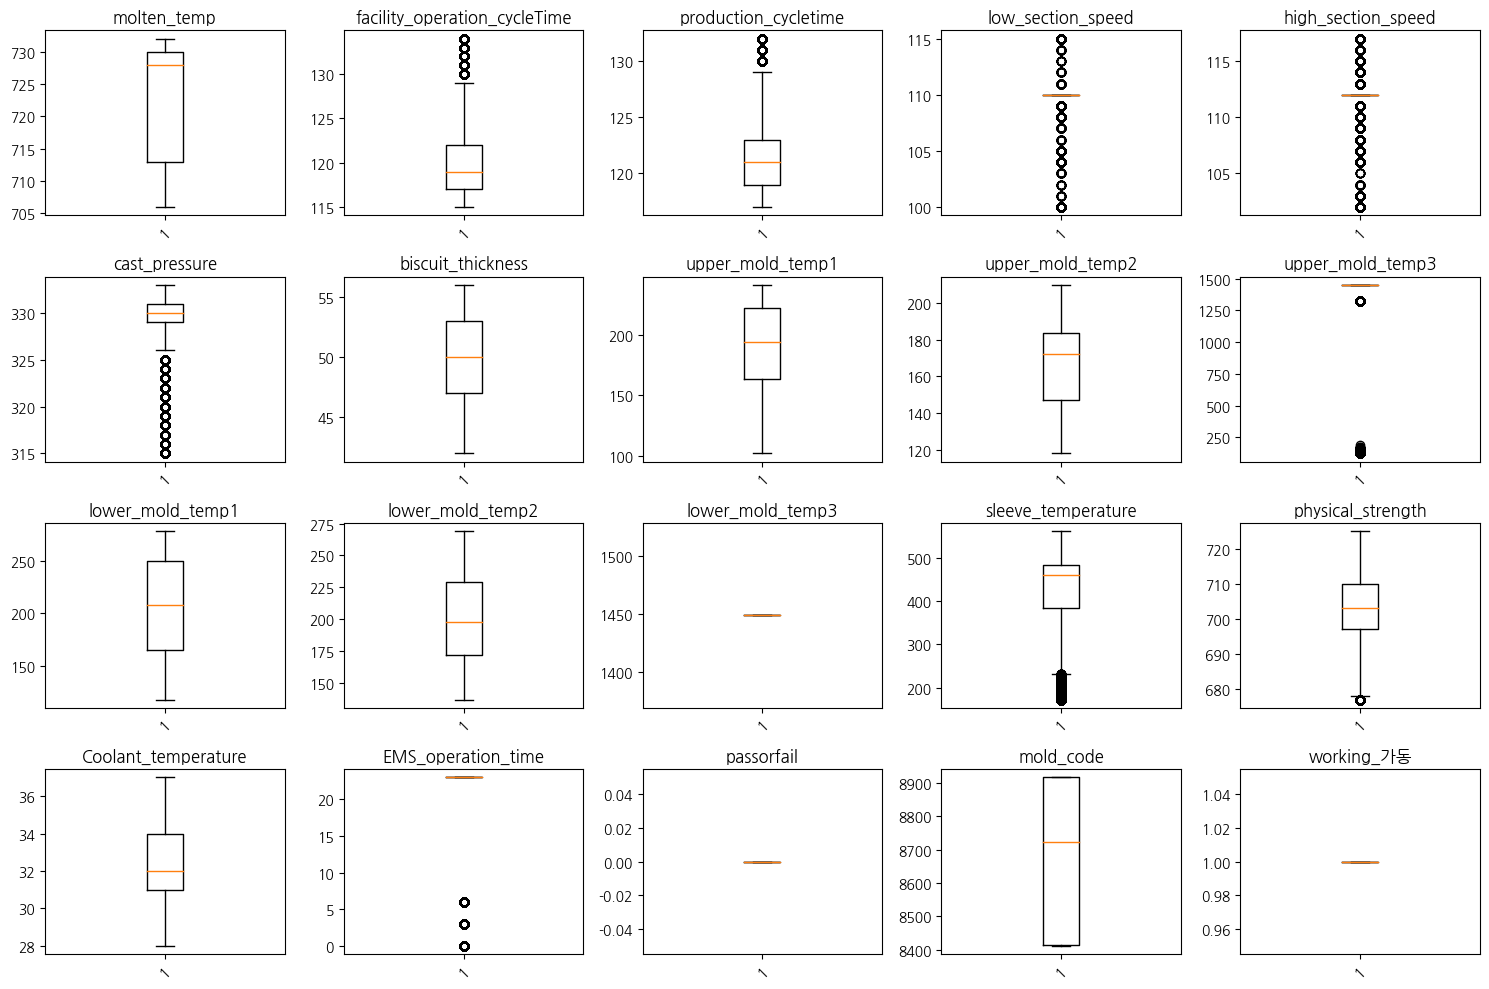

In [221]:
for col in columnsList:
    data[col] = winsorize(data[col], limits=[0.05, 0.05])

plt.figure(figsize=(15, 10))
for i, col in enumerate(columnsList, 1):
    plt.subplot(4, 5, i)  
    plt.boxplot(data[col].dropna())
    plt.title(col)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

[3] 모델 학습 전 준비
- MLP, RNN(LSTM), CNN, DNN
<hr>

- MLP (MLP, Multi-Layer Perceptron, 다층 퍼셉트론)

In [222]:
# 활동패키지 버전 체크
print(f"torch v.{torch.__version__}")
print(f"Pandas v.{pd.__version__}")

torch v.2.4.1
Pandas v.2.0.3


- RNN(LSTM)

In [223]:
scaler = StandardScaler()
featureList = ['molten_temp', 'facility_operation_cycleTime', 'production_cycletime',
       'low_section_speed', 'high_section_speed', 'cast_pressure',
       'biscuit_thickness', 'upper_mold_temp1', 'upper_mold_temp2',
       'upper_mold_temp3', 'lower_mold_temp1', 'lower_mold_temp2',
       'lower_mold_temp3', 'sleeve_temperature', 'physical_strength',
       'Coolant_temperature', 'passorfail', 'mold_code',
       'working_가동']

X = data[featureList]

y = data['EMS_operation_time'] 

X_scaled = scaler.fit_transform(X)

In [224]:
data['EMS_operation_time'] 

0        23
1        23
2        23
3        23
4        23
         ..
92010     0
92011     0
92012     0
92013     0
92014     0
Name: EMS_operation_time, Length: 92014, dtype: int64

In [225]:
y

0        23
1        23
2        23
3        23
4        23
         ..
92010     0
92011     0
92012     0
92013     0
92014     0
Name: EMS_operation_time, Length: 92014, dtype: int64

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [227]:
X_train

array([[-1.68660718,  0.59440972,  0.42868579, ...,  0.        ,
         1.17887898,  0.        ],
       [ 0.39031609,  0.59440972,  0.42868579, ...,  0.        ,
         1.17887898,  0.        ],
       [ 1.04618659, -0.7439867 , -1.24611105, ...,  0.        ,
        -1.27723844,  0.        ],
       ...,
       [-0.92142492, -0.29785456, -0.12957982, ...,  0.        ,
         0.2304772 ,  0.        ],
       [-0.26555442, -0.29785456, -0.40871263, ...,  0.        ,
         0.2304772 ,  0.        ],
       [ 0.71825134, -0.07478849, -0.40871263, ...,  0.        ,
        -1.27723844,  0.        ]])

In [228]:
# input_size = 19
# X = np.random.rand(92014, input_size).astype(np.float32)
# y = np.random.rand(92014, 1).astype(np.float32)

In [229]:
X_train=pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)
X_val=pd.DataFrame(X_val)

In [230]:
# 텐서로 변환하기 전에 NumPy 배열로 변환
train_features = torch.tensor(X_train.to_numpy(), dtype=torch.float32).view(-1, 1, input_size)
train_targets = torch.tensor(y_train.to_numpy(), dtype=torch.float32).unsqueeze(1)
val_features = torch.tensor(X_val.to_numpy(), dtype=torch.float32).view(-1, 1, input_size)
val_targets = torch.tensor(y_val.to_numpy(), dtype=torch.float32).unsqueeze(1)
test_features = torch.tensor(X_test.to_numpy(), dtype=torch.float32).view(-1, 1, input_size)
test_targets = torch.tensor(y_test.to_numpy(), dtype=torch.float32).unsqueeze(1)

In [231]:
# 커스텀 데이터셋 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features.to_numpy() 
        self.targets = targets.to_numpy().flatten() 

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        feature = torch.tensor(self.features[index], dtype=torch.float32)
        target = torch.tensor(self.targets[index], dtype=torch.float32)
        return feature, target

In [232]:
# DataSet
trainDS = CustomDataset(X_train, y_train)
valDS = CustomDataset(X_val, y_val)
testDS = CustomDataset(X_test, y_test)

# DataLoader
trainDL = DataLoader(trainDS, batch_size=64, shuffle=True)
valDL = DataLoader(valDS, batch_size=64, shuffle=False)
testDL = DataLoader(testDS, batch_size=64, shuffle=False)

In [246]:
# RNN LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTMModel, self).__init__()
        # LSTM 레이어 추가, num_layers로 깊이 설정 가능
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=0.3)
        # 드롭아웃 레이어 추가
        self.dropout = nn.Dropout(0.3)
        # 퍼셉트론층을 깊게 설정
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.fc3 = nn.Linear(hidden_size // 4, output_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])  # LSTM의 마지막 타임스텝 출력에 드롭아웃 적용
        x = F.relu(self.fc1(x))  # 활성화 함수 적용
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_layers=2):
#         super(LSTMModel, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=0.3)
#         self.dropout = nn.Dropout(0.3)
#         self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
#         self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
#         self.fc3 = nn.Linear(hidden_size // 4, output_size)

#     def forward(self, x):
#         x, _ = self.lstm(x)
#         x = self.dropout(x[:, -1, :])  
#         x = F.relu(self.fc1(x))  
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

In [234]:
## 모델 파일관련
import os 

# 저장 경로
SAVE_PATH = '../models/RNN/'

# 저장 파일명
SAVE_FILE = SAVE_PATH + 'RNNLSTMmodel_train_wb.pth'
SAVE_MODEL = SAVE_PATH + 'RNNLSTMmodel_all.pth'
SAVE_SCALER = SAVE_PATH + 'LSTMscaler.pkl'

# 경로상 폴더 존재 여부 체크
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

- 학습 및 검증 손실 계산 : MSE
- 추가적인 성능 평가 지표 : MAE, R2 스코어

In [256]:
input_size = 19
hidden_size = 64
output_size = 1
num_layers = 2

model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 성능 평가 지표 정의
r2_score = R2Score()
criterion = MeanAbsoluteError()

In [257]:
# 학습 루프
epochs = 50
train_losses, val_losses, train_r2_scores, val_r2_scores = [], [], [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_r2 = 0.0

    # 배치 단위로 학습 진행
    for features, targets in trainDL:
        features = features.view(-1, 1, input_size)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * features.size(0)
        train_r2 += r2_score(outputs.detach(), targets.unsqueeze(1)).item() * features.size(0)


    train_loss /= len(trainDL.dataset)
    train_r2 /= len(trainDL.dataset)
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2)

    # 검증 단계
    model.eval()
    val_loss, val_r2 = 0.0, 0.0
    with torch.no_grad():
        for features, targets in valDL:
            features = features.view(-1, 1, input_size)
            val_outputs = model(features)
            val_loss += criterion(val_outputs, targets.unsqueeze(1)).item() * features.size(0)
            val_r2 += r2_score(val_outputs.detach(), targets.unsqueeze(1)).item() * features.size(0)

    
    val_loss /= len(valDL.dataset)
    val_r2 /= len(valDL.dataset)
    val_losses.append(val_loss)
    val_r2_scores.append(val_r2)

    print(f'Epoch [{epoch+1}/{epochs}], MAE: {train_loss:.4f}, R2 Score: {train_r2:.4f}, Val MAE: {val_loss:.4f}, Val R2 Score: {val_r2:.4f}')


# 모델 저장
# 모델의 가중치만 저장
torch.save(model.state_dict(), SAVE_FILE)

# 전체 모델 저장 (모델의 구조와 가중치를 함께 저장)
torch.save(model, SAVE_MODEL)

# 스케일러 저장
joblib.dump(scaler, SAVE_SCALER)

Epoch [1/50], MAE: 3.8877, R2 Score: 0.2484, Val MAE: 1.0074, Val R2 Score: 0.8580
Epoch [2/50], MAE: 1.6140, R2 Score: 0.8440, Val MAE: 1.0814, Val R2 Score: 0.8887
Epoch [3/50], MAE: 1.1991, R2 Score: 0.8842, Val MAE: 0.8569, Val R2 Score: 0.9247
Epoch [4/50], MAE: 0.7845, R2 Score: 0.9258, Val MAE: 0.4575, Val R2 Score: 0.9464
Epoch [5/50], MAE: 0.4369, R2 Score: 0.9404, Val MAE: 0.2645, Val R2 Score: 0.9547
Epoch [6/50], MAE: 0.3219, R2 Score: 0.9524, Val MAE: 0.2174, Val R2 Score: 0.9572
Epoch [7/50], MAE: 0.2685, R2 Score: 0.9564, Val MAE: 0.1937, Val R2 Score: 0.9595
Epoch [8/50], MAE: 0.2253, R2 Score: 0.9620, Val MAE: 0.1996, Val R2 Score: 0.9633
Epoch [9/50], MAE: 0.2089, R2 Score: 0.9629, Val MAE: 0.1719, Val R2 Score: 0.9651
Epoch [10/50], MAE: 0.1885, R2 Score: 0.9662, Val MAE: 0.1588, Val R2 Score: 0.9675
Epoch [11/50], MAE: 0.1782, R2 Score: 0.9666, Val MAE: 0.2006, Val R2 Score: 0.9666
Epoch [12/50], MAE: 0.1665, R2 Score: 0.9676, Val MAE: 0.1628, Val R2 Score: 0.9666
E

['../models/RNN/LSTMscaler.pkl']

In [258]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTMModel, self).__init__()
        # LSTM 레이어 추가, num_layers로 깊이 설정 가능
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=0.3)
        # 드롭아웃 레이어 추가
        self.dropout = nn.Dropout(0.3)
        # 퍼셉트론층을 깊게 설정
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.fc3 = nn.Linear(hidden_size // 4, output_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])  # LSTM의 마지막 타임스텝 출력에 드롭아웃 적용
        x = F.relu(self.fc1(x))  # 활성화 함수 적용
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = torch.load('C:\Hwan\models\RNN\RNNLSTMmodel_all.pth')

pred=model(train_features)
pred

C:\Users\hwans\AppData\Local\Temp\ipykernel_22800\1103485935.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('C:\Hwan\models\RNN\RNNLSTMmodel_all.pth

tensor([[22.9555],
        [22.9541],
        [ 5.9533],
        ...,
        [22.9540],
        [22.9579],
        [ 5.9543]], grad_fn=<AddmmBackward0>)

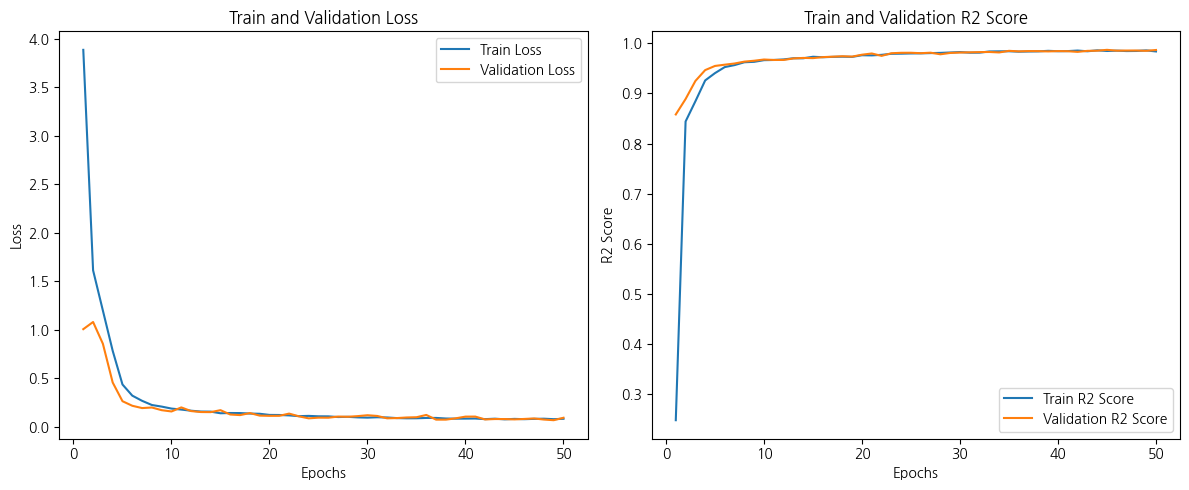

In [259]:
# 손실 및 R2 스코어 그래프 그리기
plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# R2 Score 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_r2_scores, label='Train R2 Score')
plt.plot(range(1, epochs + 1), val_r2_scores, label='Validation R2 Score')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.title('Train and Validation R2 Score')
plt.legend()

plt.tight_layout()
plt.show()

In [251]:
print(f"온실 가스 배출량 MAX : {pred.max()}")
print(f"온실 가스 배출량 MIN : {pred.min()}")
print(f"온실 가스 배출량 MEAN : {pred.mean()}")

온실 가스 배출량 MAX : 23.371986389160156
온실 가스 배출량 MIN : -0.44668257236480713
온실 가스 배출량 MEAN : 18.385805130004883


In [252]:
y.mean()

18.41101354141761

In [253]:
pred

tensor([[22.9591],
        [23.0192],
        [ 6.0017],
        ...,
        [22.9575],
        [23.0069],
        [ 5.9484]], grad_fn=<AddmmBackward0>)

In [271]:
# 온실가스 배출량 계산 
EF = 2.5  # kg CO₂/시간
pre_operation = pred
Gas = pre_operation * EF
Gas

tensor([[57.3886],
        [57.3853],
        [14.8832],
        ...,
        [57.3850],
        [57.3948],
        [14.8857]], grad_fn=<MulBackward0>)

In [270]:
print(f"예측된 온실가스 배출량 최대값: {Gas.max().item():.2f} kg CO₂")
print(f"예측된 온실가스 배출량 최소값: {Gas.min().item():.2f} kg CO₂")
print(f"예측된 온실가스 배출량 평균값: {Gas.mean().item():.2f} kg CO₂")

예측된 온실가스 배출량 최대값: 57.53 kg CO₂
예측된 온실가스 배출량 최소값: -0.75 kg CO₂
예측된 온실가스 배출량 평균값: 45.97 kg CO₂


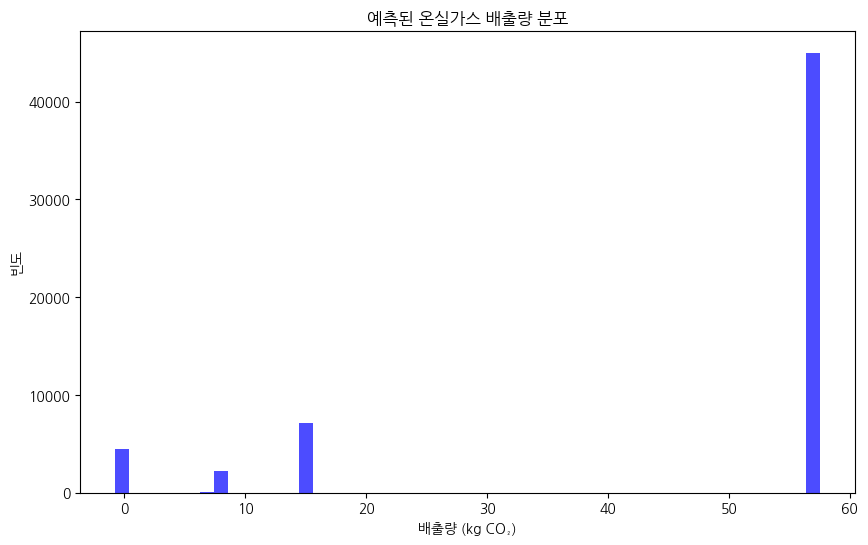

In [274]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(Gas.detach().numpy(), bins=50, color='blue', alpha=0.7)
plt.xlabel('배출량 (kg CO₂)')
plt.ylabel('빈도')
plt.title('예측된 온실가스 배출량 분포')
plt.show()